## Model_NowTV
## Table of Contents:
* [0. Importing dependencies](#dependencies)
* [1. Setting up of the dataset](#1.0)
    * [1.1 Importing of the dataset](#1.1)
    * [1.2 Splitting of the dataset](#1.2)
* [2. Model Implementation](#2.0)
    * [2.1 Model training](#2.1)


# 0. Importing dependencies  <a class="anchor" id="dependencies"></a>

In [22]:
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# 1. Setting up of the dataset <a class="anchor" id="1.0"></a>

## 1.1 Importing of the dataset <a class="anchor" id="1.1"></a>

In [23]:
# Load the final dataframe
file_path = '/content/gdrive/My Drive/df_final.csv'
df_final = pd.read_csv(file_path)

print(df_final.columns)

Index(['trend_vc', 'yearly_vc', 'weekly_vc', 'trend_i', 'yearly_i', 'weekly_i',
       'trend_ud', 'yearly_ud', 'weekly_ud', 'videoConsumption', 'impression'],
      dtype='object')


## 1.2 Splitting the dataset <a class="anchor" id="1.2"></a>

In [24]:
# Define input features and target outputs
prophet_features = ['weekly_vc', 'weekly_i', 'weekly_ud']
targets = ['videoConsumption', 'impression']

all_features = prophet_features + targets  # Include both Prophet features and original data


In [25]:
# Split dataset function
def split_dataset(df):
    idx_train_end = round(0.7 * len(df))
    idx_val_end = round(0.85 * len(df))
    return df.iloc[:idx_train_end], df.iloc[idx_train_end:idx_val_end], df.iloc[idx_val_end:]

df_train, df_val, df_test = split_dataset(df_final)

# 2. Model Implementation <a class="anchor" id="2.0"></a>

## 2.1 Model training <a class="anchor" id="2.1"></a>

In [26]:
def rolling_window_forecast_xgboost(data, window_size, forecast_horizon, model):
    predictions_vc, predictions_i = [], []
    true_values_vc, true_values_i = [], []

    for start in range(0, len(data) - window_size - forecast_horizon, forecast_horizon):
        end = start + window_size
        X_train = data[start:end]
        y_train_vc = data[start:end, -2]
        y_train_i = data[start:end, -1]

        X_test = data[end:end + forecast_horizon]
        y_test_vc = data[end:end + forecast_horizon, -2]
        y_test_i = data[end:end + forecast_horizon, -1]

        y_train = np.vstack((y_train_vc, y_train_i)).T
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        predictions_vc.extend(y_pred[:, 0])
        predictions_i.extend(y_pred[:, 1])
        true_values_vc.extend(y_test_vc)
        true_values_i.extend(y_test_i)

    return predictions_vc, predictions_i, true_values_vc, true_values_i

In [27]:
def plot_predictions(true_values, predictions, title):
    plt.figure(figsize=(10, 6))
    plt.plot(true_values, label='True Values')
    plt.plot(predictions, label='Predictions', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [28]:
# Evaluation and Model Selection
forecast_horizon = 1440  # fixed forecast horizon
window_sizes = {
    '1 day': 1440,
    '4 days': 1440 * 4,
    '1 week': 1440 * 7,
}
best_model = None
best_errors = {}
best_window_size = None
min_rmse = float('inf')

Window: 1 day
  Video Consumption - MSE: 319135115.395, RMSE: 17864.353
  Impression - MSE: 205763.470, RMSE: 453.612


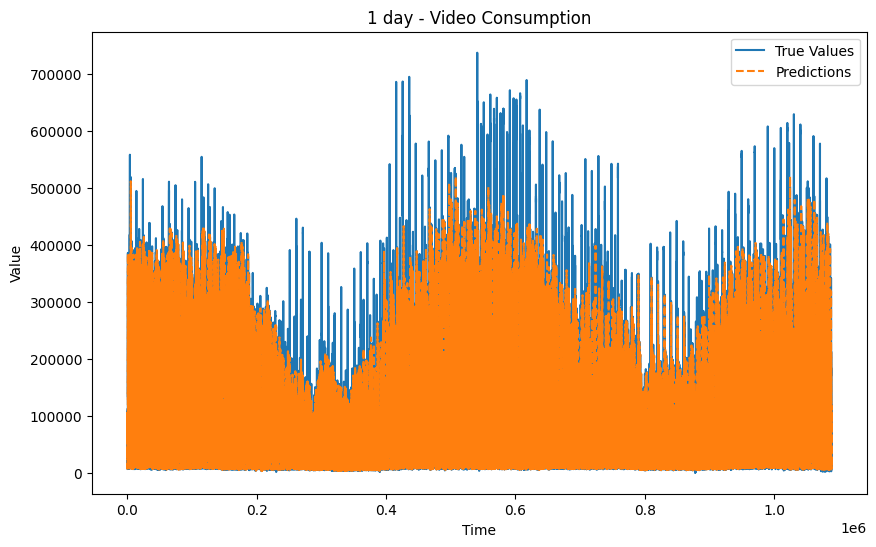

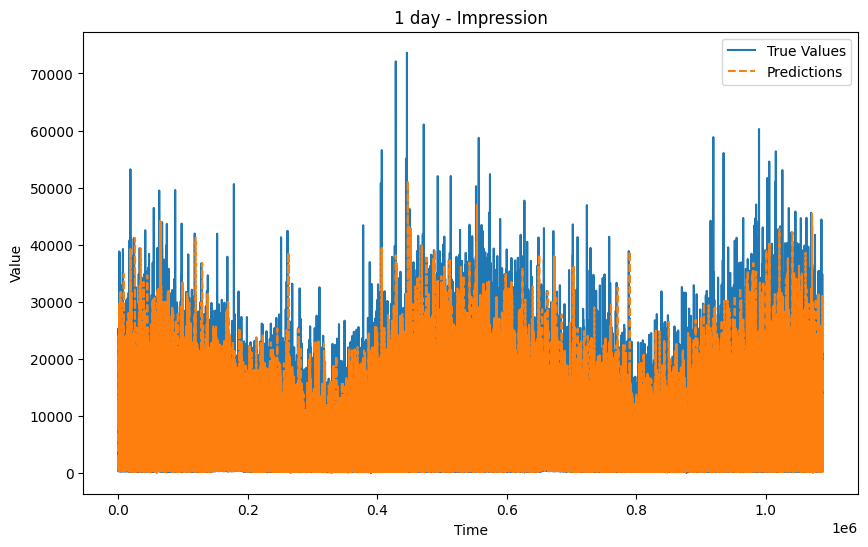

Window: 4 days
  Video Consumption - MSE: 117048169.782, RMSE: 10818.880
  Impression - MSE: 159748.407, RMSE: 399.685


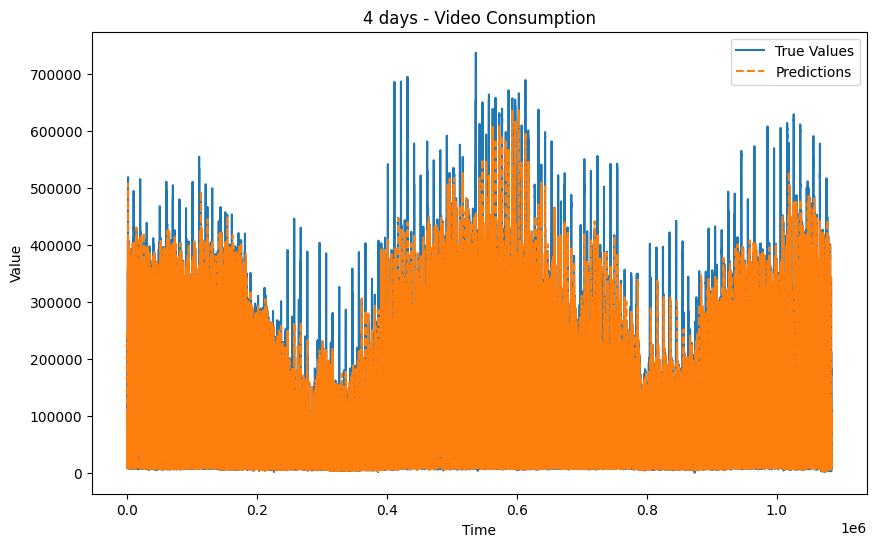

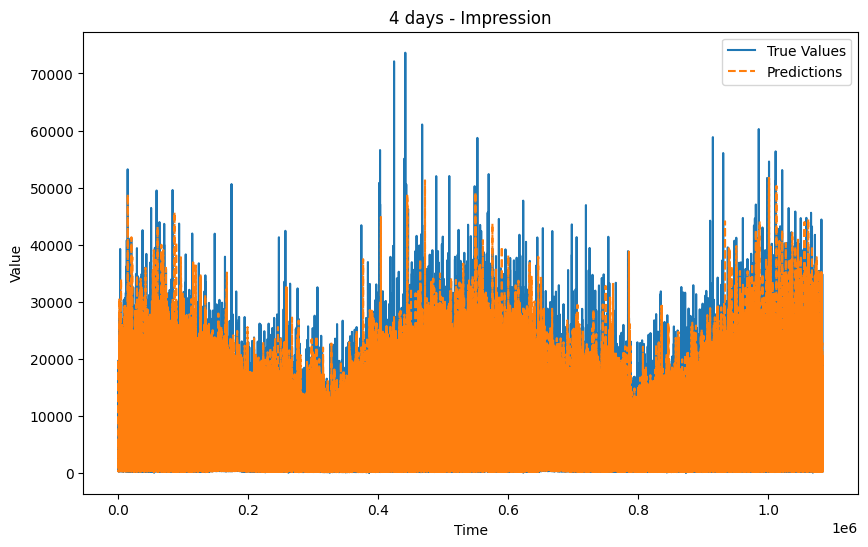

Window: 1 week
  Video Consumption - MSE: 25464002.251, RMSE: 5046.187
  Impression - MSE: 139947.074, RMSE: 374.095


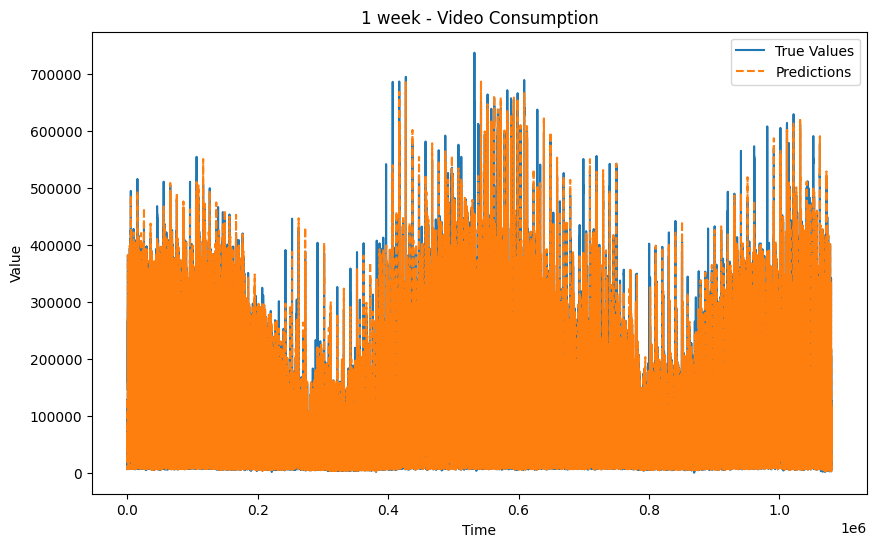

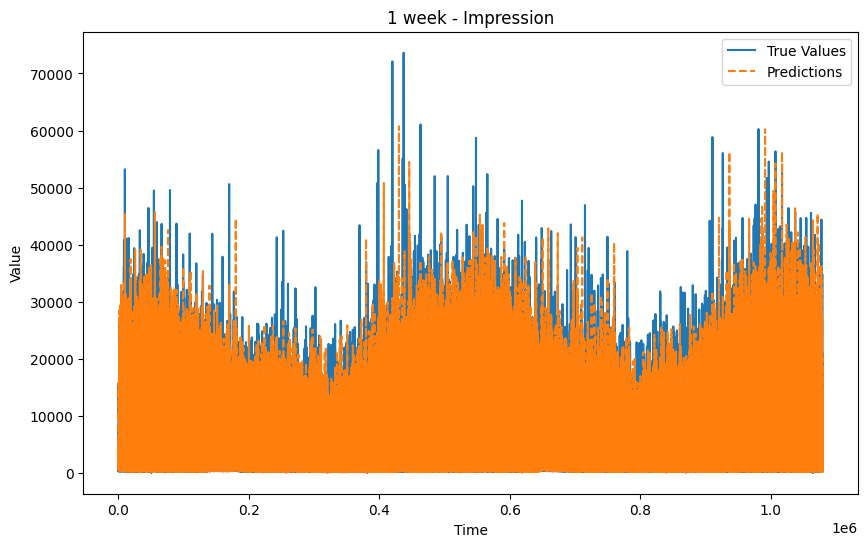

In [29]:
# Evaluate model for each window size
train_data = df_train[all_features].dropna().values

for window_name, window_size in window_sizes.items():
    model = MultiOutputRegressor(xgb.XGBRegressor(random_state=42))

    predictions_vc, predictions_i, true_values_vc, true_values_i = rolling_window_forecast_xgboost(train_data, window_size, forecast_horizon, model)

    mse_vc = mean_squared_error(true_values_vc, predictions_vc)
    rmse_vc = sqrt(mse_vc)
    mse_i = mean_squared_error(true_values_i, predictions_i)
    rmse_i = sqrt(mse_i)

    if rmse_vc + rmse_i < min_rmse:
        min_rmse = rmse_vc + rmse_i
        best_window_size = window_size
        best_model = model

    best_errors[window_name] = {
        'MSE_vc': mse_vc,
        'RMSE_vc': rmse_vc,
        'MSE_i': mse_i,
        'RMSE_i': rmse_i
    }

    print(f"Window: {window_name}")
    print(f"  Video Consumption - MSE: {mse_vc:.3f}, RMSE: {rmse_vc:.3f}")
    print(f"  Impression - MSE: {mse_i:.3f}, RMSE: {rmse_i:.3f}")

    plot_predictions(true_values_vc, predictions_vc, f'{window_name} - Video Consumption')
    plot_predictions(true_values_i, predictions_i, f'{window_name} - Impression')


In [31]:
# Save the best model
model_filename = '/content/gdrive/My Drive/XGBoost_rw_add_best_model.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to /content/gdrive/My Drive/XGBoost_rw_add_best_model.pkl


In [32]:
# Print best window size
print("\nBest Window Size:")
print(best_window_size)


Best Window Size:
10080


In [33]:
print("\nBest Model Parameters:")
print(best_model.estimators_[0].get_params())


Best Model Parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [34]:
print("\nBest Model Features Importance:")
print(best_model.estimators_[0].feature_importances_)


Best Model Features Importance:
[4.87363752e-04 1.09358574e-04 6.79138175e-05 9.99265730e-01
 6.95988492e-05]
